In [37]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
sys.path.insert(1, os.path.join(sys.path[0], '../../'))  # for importing local packages from src

%reload_ext autoreload
%autoreload 2 

### Loading datasets

In [38]:
DATASET_NEMA_H0 = '../datasets/dataset_NEMA_NEMA_H0.csv'
DATASET_NEMA_H3 = '../datasets/dataset_NEMA_NEMA_H3.csv'
DATASET_NEMA_H15 = '../datasets/dataset_NEMA_NEMA_H15.csv'

In [149]:
from src.model.rc_dataset import ExperimentDataset


dataset_nema_h0 = ExperimentDataset(csv_path=DATASET_NEMA_H0)
dataset_nema_h3 = ExperimentDataset(csv_path=DATASET_NEMA_H3)
dataset_nema_h15 = ExperimentDataset(csv_path=DATASET_NEMA_H15)

datasets = [dataset_nema_h0, dataset_nema_h3, dataset_nema_h15]

### Target generator

In [155]:
from model_config import targets
from pipeline_cnwheat import TargetGenerator

target_generator = TargetGenerator(target=targets[0])
y_raw = target_generator.transform(datasets, warmup_days=4)

print(f'y_raw shape: {y_raw.shape}')

y_raw shape: (1, 2136)


### Reservoir generators

#### Homogeneous reservoirs

In [156]:
from model_config import state_variables
from pipeline_cnwheat import SingleReservoirGenerator


reservoir_generator = SingleReservoirGenerator(state_var=state_variables[2])
X_raw = reservoir_generator.transform(datasets, warmup_days=4)

print(f'X_raw shape: {X_raw.shape}')

X_raw shape: (1, 2136, 10)


#### Heterogeneous reservoirs

In [157]:
from pipeline_cnwheat import MultiReservoirGenerator


reservoir_generator = MultiReservoirGenerator(state_vars=state_variables)
X_raw = reservoir_generator.transform(datasets, warmup_days=4)

print(f'X_raw shape: {X_raw.shape}')

X_raw shape: (1, 2136, 122)


#### Environment baseline reservoirs

In [158]:
from model_config import input_targets
from pipeline_cnwheat import TargetReservoirGenerator


reservoir_generator = TargetReservoirGenerator(targets=input_targets)
X_raw = reservoir_generator.transform(datasets, warmup_days=4)

print(f'X_raw shape: {X_raw.shape}')

X_raw shape: (1, 2136, 3)


### Group generator

In [163]:
from pipeline_cnwheat import GroupGenerator


group_generator = GroupGenerator(day_length=24)

groups_raw = group_generator.transform(datasets, warmup_days=4)

print(f'Groups_raw shape: {groups_raw.shape}')
print(f'Unique groups: {len(np.unique(groups_raw))}')
print(groups_raw[0, 0:7*24:24])

Groups_raw shape: (1, 2136)
Unique groups: 33
[0. 1. 2. 3. 4. 5. 6.]


### Target transformers

In [51]:
class TargetTransformer(ABC):

  @abstractmethod
  def transform(self, y_raw: np.ndarray) -> np.ndarray:
    pass

#### Direct target (no transform)

In [52]:
class DirectTarget(TargetTransformer):

  def transform(self, y_raw: np.ndarray) -> np.ndarray:
    return y_raw

In [53]:
target_tf = DirectTarget()
y_tf = target_tf.transform(y_raw)

print(y_tf.shape)

(1, 2136)


### Reservoir transformers

In [54]:
class ReservoirTransformer(ABC):

  @abstractmethod
  def transform(self, X_raw: np.ndarray) -> np.ndarray:
    pass

#### Direct reservoir (no transform)

In [55]:
class DirectReservoir(ReservoirTransformer):

  def transform(self, X_raw: np.ndarray) -> np.ndarray:
    return X_raw

In [56]:
reservoir_tf = DirectReservoir()
X_tf = reservoir_tf.transform(X_raw)

print(X_tf.shape)

(1, 2136, 3)


### Flatten data

In [57]:
from typing import Tuple

def flatten(X_tf, y_tf, groups) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
  assert X_tf.shape[:2] == y_tf.shape == groups.shape
  _, n_samples, n_features = X_tf.shape
  X = X_tf.reshape((-1, n_features))
  y = y_tf.reshape((n_samples))
  groups = groups.reshape((n_samples))
  return X, y, groups

In [58]:
X, y, groups = flatten(X_tf, y_tf, groups_raw)

print(X.shape)
print(y.shape)
print(groups.shape)

(2136, 3)
(2136,)
(2136,)


### Data preprocessors

In [59]:
class Preprocessor(ABC):

  @abstractmethod
  def transform(self, X, y, groups) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    return X, y, groups

#### Daylight masking

In [60]:
from src.learning.preprocessing import generate_mask

class DaylightMask(Preprocessor):

  def __init__(self, *, day_length: int, start: int, end: int):
    self.daylight_mask = generate_mask(start, end, length=day_length)

  def transform(self, X, y, groups) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    assert len(X) == len(y) == len(groups)
    n_days = X.shape[0] // len(self.daylight_mask)
    time_mask = np.tile(self.daylight_mask, n_days)
    X = X[time_mask]
    y = y[time_mask]
    groups = groups[time_mask]
    return X, y, groups

In [61]:
day_mask_tf = DaylightMask(day_length=24, start=5, end=21)
X_day, y_day, groups_day = day_mask_tf.transform(X, y, groups)

print(X_day.shape, y_day.shape, groups_day.shape)

(1424, 3) (1424,) (1424,)


#### Rescaling

In [62]:
from sklearn.preprocessing import StandardScaler

class Rescale(Preprocessor):

  def __init__(self, *, per_feature):
    self.per_feature = per_feature

  def transform(self, X, y, groups) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    if self.per_feature:
      X = StandardScaler().fit_transform(X)
    else:
      X = (X - X.mean()) / X.std()
    y = (y - y.mean()) / y.std()
    return X, y, groups

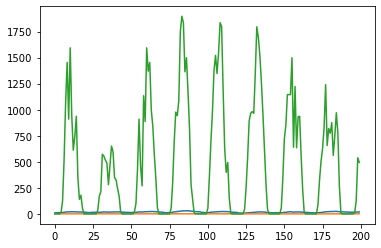

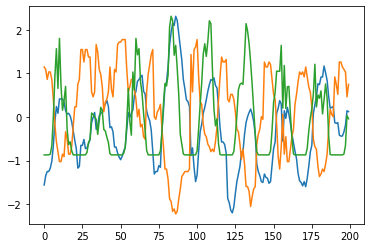

In [63]:
plt.plot(X[:200])
plt.show()

scaler_tf = Rescale(per_feature=True)
X_scaled, _, _ = scaler_tf.transform(X, y, groups)

plt.plot(X_scaled[:200])
plt.show()

### Train-test splitter

In [82]:
sample_set = Tuple[np.ndarray, np.ndarray, np.ndarray]


class BaseTrainTestSplitter(ABC):

  def __init__(self, *, block_size: int, test_ratio: float):
    assert test_ratio <= 0.5, "Test ratio can be at most 50 percent of the data"
    self.block_size = block_size
    self.test_ratio = test_ratio

  @abstractmethod
  def transform(self, X, y, groups) -> Tuple[sample_set, sample_set]:
    return X, y, groups

In [83]:
class TrainTestSplitter(BaseTrainTestSplitter):

  def transform(self, X, y, groups) -> Tuple[sample_set, sample_set]:

    group_ids = np.unique(groups)

    base_length = int(np.round(1 / self.test_ratio))

    train_groups_mask = np.ones((base_length), dtype=bool)
    train_groups_mask[-1] = False
    train_groups_mask = np.repeat(train_groups_mask, self.block_size)
    train_groups_mask = np.tile(
        train_groups_mask, np.ceil(len(group_ids) / len(train_groups_mask)).astype(int)
    )
    train_groups_mask = train_groups_mask[: len(group_ids)]
    train_group_ids = group_ids[train_groups_mask]
    train_mask = np.isin(groups, train_group_ids)

    X_train = X[train_mask]
    groups_train = groups[train_mask]
    y_train = y[train_mask]

    X_test = X[~train_mask]
    y_test = y[~train_mask]
    groups_test = groups[~train_mask]

    return (X_train, y_train, groups_train), (X_test, y_test, groups_test)


In [87]:
splitter = TrainTestSplitter(block_size=4, test_ratio=0.5)
train, test = splitter.transform(X, y, groups)

print(train[0].shape, test[0].shape)

(1104, 3) (1032, 3)


### Pipeline definition

In [132]:
from dataclasses import dataclass
from typing import Callable

from sklearn.base import BaseEstimator
from sklearn.model_selection import BaseCrossValidator


BaseScorer = Callable[[BaseEstimator, np.ndarray, np.ndarray], float]

@dataclass
class RCPipeline:
  # Metadata (added as columns in the results dict)
  metadata: dict

  # Data generation
  datasets: List[ExperimentDataset]
  target: BaseTargetGenerator
  reservoir: BaseReservoirGenerator
  groups: BaseGroupGenerator

  # Data transformation
  warmup_days: int
  target_tf: TargetTransformer
  reservoir_tf: ReservoirTransformer

  # Data preproccessing
  preprocessing: List[Preprocessor]

  # Model
  train_test_split: BaseTrainTestSplitter
  readout_model: BaseEstimator
  model_param_grid: dict
  model_scorer: BaseScorer
  folds: BaseCrossValidator


##### Test example

In [144]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import LeaveOneGroupOut

from src.learning.scorers import nmse_scorer

# Reservoir definition
reservoir_id = 'state__het_all'
reservoir = MultiReservoirGenerator(state_vars=state_variables)
reservoir_tf = DirectReservoir()

# Target definition
target_id = 'input_air_temperature'
target = TargetGenerator(target=target_id)
target_tf = DirectTarget()

# Model definition
readout = Pipeline([
  ('ridge_regression', Ridge(alpha=1, fit_intercept=True))
])

search_grid = [{
  'ridge_regression__alpha': 10 ** np.linspace(np.log10(1e-4), np.log10(1e2), 50)
}]

pipeline = RCPipeline(
  # Metadata
  metadata={
    'target_id': target_id,
    'reservoir_id': reservoir_id,
    'dataset_id': 'NEMA_combined',
  },

  # Data generation
  datasets=datasets,
  target=target,
  reservoir=reservoir,
  groups=GroupGenerator(day_length=24),

  # Data transformation
  warmup_days=4,
  reservoir_tf=reservoir_tf,
  target_tf=target_tf,

  # Data preprocessing
  preprocessing=[
    DaylightMask(day_length=24, start=5, end=21),
    Rescale(per_feature=False)
  ],

  # Model training and testing
  train_test_split=TrainTestSplitter(block_size=4, test_ratio=0.5),
  readout_model=readout,
  model_param_grid=search_grid,
  model_scorer=nmse_scorer,
  folds=LeaveOneGroupOut(),
)

### Pipeline execution

In [145]:
from sklearn.base import clone as clone_model

from src.learning.training import perform_gridsearch


def fit_model(model, X, y, groups, folds, search_grid) -> BaseEstimator:
  """Optimizes model using param search grid and returns the optimal model."""
  cv_model, cv_scores = perform_gridsearch(
    model, X,  y, groups, folds, search_grid, verbose=False
  )
  final_model = clone_model(model)
  final_model.set_params(**cv_model.best_params_)
  final_model.fit(X, y)
  return final_model, cv_scores


def execute_pipeline(pipeline: RCPipeline):

  # Data generation
  X_raw = pipeline.reservoir.transform(datasets, warmup_days=pipeline.warmup_days)
  y_raw = pipeline.target.transform(datasets, warmup_days=pipeline.warmup_days)
  groups_raw = pipeline.groups.transform(datasets, warmup_days=pipeline.warmup_days)

  # Data transformation
  X_tf = pipeline.reservoir_tf.transform(X_raw)
  y_tf = pipeline.target_tf.transform(y_raw)
  X, y, groups = flatten(X_tf, y_tf, groups_raw)

  # Data processing
  for processor in pipeline.preprocessing:
    X, y, groups = processor.transform(X, y, groups)

  # Train test splitting
  train, test = pipeline.train_test_split.transform(X, y, groups)

  # Model training
  X_train, y_train, groups_train = train
  final_model, cv_scores = fit_model(
    pipeline.readout_model, X_train, y_train, groups_train, 
    pipeline.folds, pipeline.model_param_grid
  )
  (train_mean, train_std), (cv_mean, cv_std) = cv_scores

  # Model evaluation
  X_test, y_test, _ = test
  test_score = pipeline.model_scorer(final_model, X_test, y_test)
  result_dict = {
    **pipeline.metadata,
    "test_score": test_score,
    "train_mean": train_mean,
    "train_std": train_std,
    "cv_mean": cv_mean,
    "cv_std": cv_std,
  }
  
  return result_dict

results = execute_pipeline(pipeline)

print(results)

{'target_id': 'input_air_temperature', 'reservoir_id': 'state__het_all', 'dataset_id': 'NEMA_combined', 'test_score': -0.047169589011037065, 'train_mean': -0.038991294558955, 'train_std': 0.0029223571396617184, 'cv_mean': -0.20472957240013542, 'cv_std': 0.19331493044810283}
